# 4. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 **최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련**시켜 봅시다.  
데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지마세요!

참고 : [[연구원의 AI 논문리뷰] Cutmix: Regularization strategy to train strong classifiers with localizable features](https://www.youtube.com/watch?v=INEaSakYb-U)

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

## 0. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()

# 사용할 데이터셋을 불러오기
(ds_train, ds_test), ds_info = tfds.load(name='stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True,
                                         )
print('train dataset :', len(ds_train))
print('test dataset :', len(ds_test))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
train dataset : 12000
test dataset : 8580


### 데이터셋 정보 확인

In [4]:
# 데이터셋의 정보 확인
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

In [5]:
# feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


* 입력이미지의 크기는 (None, None, 3)이며, 데이터 타입은 tf.uint8 이다.

In [6]:
# splits 정보 확인
print(ds_info.splits)

{Split('train'): <SplitInfo num_examples=12000, num_shards=4>, Split('test'): <SplitInfo num_examples=8580, num_shards=4>}


In [7]:
# 데이터 개수 확인
print('train :', ds_info.splits['train'])
print('test  :', ds_info.splits['test'])

train : <SplitInfo num_examples=12000, num_shards=4>
test  : <SplitInfo num_examples=8580, num_shards=4>


In [8]:
# 데이터 개수 확인 
print('train :', tf.data.experimental.cardinality(ds_train))
print('test  :', tf.data.experimental.cardinality(ds_test))

train : tf.Tensor(12000, shape=(), dtype=int64)
test  : tf.Tensor(8580, shape=(), dtype=int64)


In [9]:
# 클래스의 개수 확인
num_classes = ds_info.features["label"].num_classes
print('class 개수 :', num_classes)

class 개수 : 120


In [10]:
# 클래스의 이름 확인
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

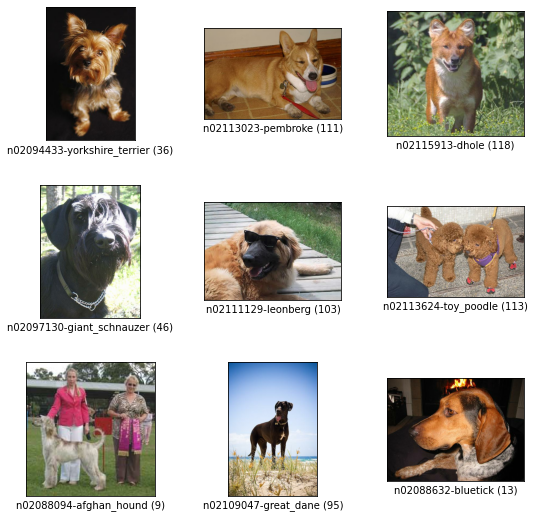

In [11]:
# 불러온 데이터셋 시각화
fig = tfds.show_examples(ds_train, ds_info)

* `tfds.show_examples()` :

## 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 **데이터셋에 CutMix 또는 Mixup augmentation을 적용**해 주세요.

### 데이터셋에 augmentation 적용하는 함수

In [12]:
# 정규화 및 이미지 크기 변경하는 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])          
    image = tf.cast(image, tf.float32) / 255.           # 0~1 사이의 float32로 정규화
    return image, label

# label 원-핫 인코딩하는 함수
def onehot(image, label):
    onehot_label = tf.one_hot(label, num_classes,
                       on_value=1.0, off_value=0.0)
    return image, onehot_label


# 좌우 대칭 및 밝기 변경하는 함수
def augment(image,label):
    image = tf.image.random_flip_left_right(image)             # 좌우 대칭
    image = tf.image.random_brightness(image, max_delta=0.2)   # 밝기 변경
    return image, label


# 데이터셋에 augmentation 적용하는 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    # 위에서 만든 normalize 함수를 병렬로 map 하기
    ds = ds.map(
        normalize_and_resize_img,   # 기본적인 전처리 함수 적용
        num_parallel_calls=2        # 병렬처리할 때 가용할 CPU 코어 개수
    )
    # apply base augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    # split dataset into batches of batch_size    
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:      # apply CutMix augmentation
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:     # apply MixUP augmentation
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:                                # apply one-hot encoding
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

**원-핫 인코딩**

[참고1](https://teddylee777.github.io/machine-learning/python-numpy%EB%A1%9C-one-hot-encoding-%EC%89%BD%EA%B2%8C%ED%95%98%EA%B8%B0)  
[참고2](https://nicola-ml.tistory.com/62)  
[참고3](https://velog.io/@sset2323/02-05.-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC)  
[참고4: 분류기 학습을 위한 One-Hot encoding 라벨 생성하기](https://deep-eye.tistory.com/67)  
[참고5: 데이터 전처리하기](https://nicola-ml.tistory.com/62)  

In [13]:
# 데이터셋 불러오기
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True,
                                         )

* `as_supervised=True` : dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다.  [참고](https://teddylee777.github.io/tensorflow/tfds-datasets)

### Augmentation 적용하지 않은 데이터셋 생성

In [14]:
# Augmentation 적용하지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test_no_aug  = apply_normalize_on_dataset(ds_test, is_test=True)

### 기본 Augmentation 적용한 데이터셋 생성

In [15]:
# 기본 Augmentation 적용한 데이터셋 생성
ds_train_base_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test_base_aug = apply_normalize_on_dataset(ds_test,  with_aug=True, is_test=True)

* label 은 어떻게 전달되는 것인지?
  - dataset에 image, label 튜플로 제공된다

### Augmentation - CutMix 

#### 2개의 이미지  가져오기

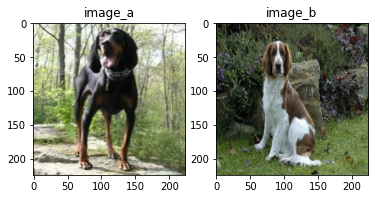

In [16]:
# 데이터셋에서 이미지 2개를 가져오기 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):  
    # print(image.shape)  # (16, 224, 224, 3)
    # print(label.shape)  # (16,)
    
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.title("image_a")
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.title("image_b")
plt.imshow(image_b)

* [참고: tfds.load()후 데이터 기능 보강을 적용하는 방법](https://www.javaer101.com/ko/article/1055322.html)

####  삽입될 영역의 바운딩 박스의 위치

In [17]:
# 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]   # width
    image_size_y = image_a.shape[0]   # height
    
    # get entire area of box
    x = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_x), tf.int32)
    y = tf.cast( tf.random.uniform([], minval=0, maxval=image_size_y), tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)        # get point starting in an area larger than 0       
    ya = tf.math.maximum(0, y-height//2)              
    xb = tf.math.minimum(image_size_x, x+width//2)   # get point ending in an area smaller than the image size
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(11, shape=(), dtype=int32) tf.Tensor(124, shape=(), dtype=int32) tf.Tensor(168, shape=(), dtype=int32)


* `tf.random.uniform(shape, minval=0, maxval=None, dtype=tf.dtypes.float32, seed=None, name=None)`  :
  - Outputs random values from a uniform distribution.
  - [참고: tf.random.uniform](https://www.tensorflow.org/api_docs/python/tf/random/uniform)


* bounding box coordinates : B = $(r_x, r_y, r_w, r_h)$
* the cropped area ratio : $\frac{r_w r_h}{W H} = 1−λ$
  - $r_w = W \sqrt{1−λ}$
  - $r_h = H \sqrt{1−λ}$
  - 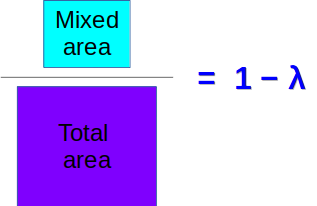

#### 2개 이미지 합치기

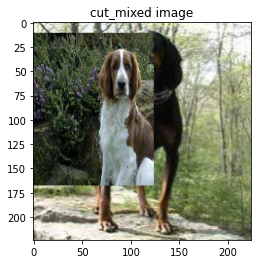

In [18]:
# 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # combine areas divided into five parts
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)

plt.title("cut_mixed image")
plt.imshow(mixed_img.numpy())

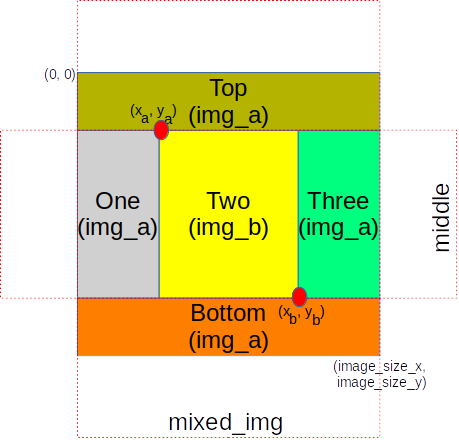

#### 면적 비율로 라벨을 합치기

In [19]:
# 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    # calculate the area ratio
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)    # a = 1 − λ

    # print(label_a.shape)
    # print(len(label_a.shape))
    
    # apply one-hot encoding
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    
    # 면적 비율만큼 라벨값 할당
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
print('cut_mixed label :', mixed_label)

cut_mixed label : tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.6120057  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.38799426 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

#### 배치 단위의 cutmix() 함수

In [20]:
# 배치 단위의 cutmix() 함수
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)  # 0 =< j < 16
        image_b = image[j]  
        label_b = label[j]
        
        # 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

* `tf.stack(values, axis=0, name='stack')` : [참조](https://www.tensorflow.org/api_docs/python/tf/stack)
  - if axis == 0 then the output tensor will have the shape (N, A, B, C)
  - if axis == 1 then the output tensor will have the shape (A, N, B, C)

#### CutMix Augmentation 적용한 데이터셋 생성

In [21]:
# CutMix Augmentation 적용한 데이터셋 생성
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_cutmix=True) 
ds_test_cutmix_aug  = apply_normalize_on_dataset(ds_test,  with_cutmix=True, is_test=True)

### Augmentation - MixUp 

#### 이미지 섞기

mixup_label : 
 tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.6120057  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.38799426 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

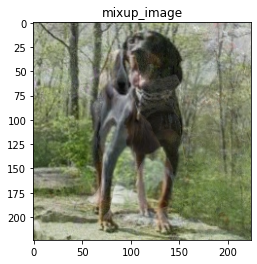

In [22]:
# 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 함수
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    # 혼합 비율 선택
    a = tf.random.uniform([],0,1)
    
    # apply one-hot encoding of labels
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
        
    mixed_image = (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

plt.title('mixup_image')
plt.imshow(mixed_img.numpy())
print('mixup_label : \n', mixed_label)

#### 배치 단위의 mixup() 함수

In [23]:
# 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 봅시다.
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

#### MixUp Augmentation 적용한 데이터셋 생성

In [24]:
# MixUp Augmentation 적용한 데이터셋 생성
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_mixup=True) 
ds_test_mixup_aug  = apply_normalize_on_dataset(ds_test,  with_mixup=True, is_test=True)

## 2. 모델 만들기

앞서 만들었던 것처럼 **비교실험을 위한 모델 두 개를 만들**어 주세요. 모델은 **ResNet-50**을 사용합시다.


### 학습할  ResNet-50 모델 

In [25]:
# Augmentation을 적용하지 않은 데이터셋으로 학습시킬 ResNet
resnet50_no_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

94773248/94765736 [==============================] - 1s 0us/step


In [26]:
# 기본 Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_base_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [27]:
# CutMix Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_cutmix_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [28]:
# MixUp Augmentation을 적용한 데이터셋으로 학습시킬 ResNet
resnet50_mixup_aug = keras.models.Sequential([
    # ResNet50 중 imagenet에 훈련된 모델을 불러오기
    keras.applications.resnet.ResNet50(
        include_top=False,    # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    # fully connected layer 추가
    keras.layers.Dense(num_classes, activation = 'softmax')
])

## 3. 모델 훈련하기

**모델을 훈련**시켜 주세요.

힌트: 위에서 만든 **CutMix나 Mixup**을 사용하기 위해서는   
앞에서 **resnet50과 aug_resnet50**을 훈련하는 데 사용했던 **sparse_categorical_crossentropy()** 대신   
**categorical_crossentropy()** 를 사용해주세요!

In [29]:
# 하이퍼파라미터 설정
BATCH_SIZE = 16
EPOCH = 20  # 20  # Augmentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)

### Augmentation 적용하지 않은 경우

In [30]:
# Augmentation 적용하지 않은 경우
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

* 손실함수 비교 : 
[손실함수 정리](https://han-py.tistory.com/266)
[Keras에서 binary_crossentropy와 categorical_crossentropy 차이](https://utto.tistory.com/8)
[logistic regression](https://gentlej90.tistory.com/69)
[참고1](https://ahnjg.tistory.com/88)
[참고2](https://crazyj.tistory.com/153)
[참고3](https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c)

  - **`sparse_categorical_crossentropy`** : [소스코드](https://github.com/tensorflow/tensorflow/blob/1cf0898dd4331baf93fe77205550f2c2e6c90ee5/tensorflow/python/ops/nn_ops.py#L3304)
    - 다중 분류 손실함수
    - 일치 가능성 이 가장 높은 카테고리의 카테고리 색인을 생성
    - y_true의 입력이 integer type 클래스
    - y_true의 입력이 `[0, 1, 2]`  (배치 사이즈 3개로 했을 때)
    - 각 샘플이 오직 하나의 class에 속할 때 사용

  - **`categorical_crossentropy`** : [소스코드](https://github.com/tensorflow/tensorflow/blob/1cf0898dd4331baf93fe77205550f2c2e6c90ee5/tensorflow/python/keras/backend.py#L4426)
    - 다중 분류 손실함수
    - 각 범주에 대한 일치 가능성이있는 원-핫 배열을 생성
    - 출력 값이 one-hot encoding된 결과로 나온다
    - label(y)을 one-hot encoding 해서 넣어줘야 함
    - y_true의 입력이 `[[0 0 1] [0 1 0] [1 0 0]]`  (배치 사이즈 3개인 경우)
    - 각 샘플이 여러개의 class에 속할 수 있을 때 사용하거나 
    - label이 soft 확률일 때 사용 (`[0.5, 0.3, 0.2]`)
      
  - **`binary_crossentropy`** : [소스코드](https://github.com/tensorflow/tensorflow/blob/1cf0898dd4331baf93fe77205550f2c2e6c90ee5/tensorflow/python/keras/backend.py#L4559)
    - binary 다중 분류 손실 함수
    - label들이 독립적일 때 사용


In [31]:
# Augmentation 적용하지 않은 경우
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 355s 433ms/step - loss: 3.2116 - accuracy: 0.2699 - val_loss: 3.4684 - val_accuracy: 0.1961
Epoch 2/20
750/750 [==============================] - 327s 436ms/step - loss: 0.9124 - accuracy: 0.7469 - val_loss: 1.0723 - val_accuracy: 0.6868
Epoch 3/20
750/750 [==============================] - 326s 435ms/step - loss: 0.3228 - accuracy: 0.9241 - val_loss: 0.9571 - val_accuracy: 0.7256
Epoch 4/20
750/750 [==============================] - 327s 436ms/step - loss: 0.0964 - accuracy: 0.9865 - val_loss: 0.8949 - val_accuracy: 0.7425
Epoch 5/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0320 - accuracy: 0.9983 - val_loss: 0.8960 - val_accuracy: 0.7479
Epoch 6/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.9079 - val_accuracy: 0.7479
Epoch 7/20
750/750 [==============================] - 326s 435ms/step - loss: 0.0126 - accuracy: 0.9998 - val_loss: 0.9215 -

### 기본 Augmentation 적용한 경우

In [32]:
# 기본 Augmentation 적용한 경우
resnet50_base_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [33]:
# 기본 Augmentation 적용한 경우
history_resnet50_base_aug = resnet50_base_aug.fit(
    ds_train_base_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_base_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 333s 436ms/step - loss: 3.2070 - accuracy: 0.2771 - val_loss: 3.3844 - val_accuracy: 0.2027
Epoch 2/20
750/750 [==============================] - 326s 435ms/step - loss: 1.0621 - accuracy: 0.6931 - val_loss: 1.2063 - val_accuracy: 0.6519
Epoch 3/20
750/750 [==============================] - 326s 434ms/step - loss: 0.5842 - accuracy: 0.8322 - val_loss: 1.2351 - val_accuracy: 0.6439
Epoch 4/20
750/750 [==============================] - 326s 434ms/step - loss: 0.3140 - accuracy: 0.9240 - val_loss: 1.0035 - val_accuracy: 0.7116
Epoch 5/20
750/750 [==============================] - 326s 435ms/step - loss: 0.1698 - accuracy: 0.9656 - val_loss: 1.0138 - val_accuracy: 0.7193
Epoch 6/20
750/750 [==============================] - 326s 434ms/step - loss: 0.0772 - accuracy: 0.9893 - val_loss: 0.9617 - val_accuracy: 0.7396
Epoch 7/20
750/750 [==============================] - 326s 434ms/step - loss: 0.0474 - accuracy: 0.9945 - val_loss: 0.9390 -

### CutMix Augmentation 적용한 경우

In [34]:
# CutMix Augmentation 적용한 경우
resnet50_cutmix_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [35]:
# CutMix Augmentation 적용한 경우
history_resnet50_cutmix_aug = resnet50_cutmix_aug.fit(
    ds_train_cutmix_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_cutmix_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 330s 432ms/step - loss: 4.3362 - accuracy: 0.1179 - val_loss: 3.6262 - val_accuracy: 0.1814
Epoch 2/20
750/750 [==============================] - 323s 431ms/step - loss: 3.0560 - accuracy: 0.4037 - val_loss: 1.4406 - val_accuracy: 0.6122
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 2.6678 - accuracy: 0.5210 - val_loss: 1.2079 - val_accuracy: 0.6525
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 2.4656 - accuracy: 0.5990 - val_loss: 1.4371 - val_accuracy: 0.6044
Epoch 5/20
750/750 [==============================] - 323s 431ms/step - loss: 2.2745 - accuracy: 0.6587 - val_loss: 1.3667 - val_accuracy: 0.6349
Epoch 6/20
750/750 [==============================] - 323s 431ms/step - loss: 2.1775 - accuracy: 0.6808 - val_loss: 1.5019 - val_accuracy: 0.6096
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 2.0665 - accuracy: 0.7150 - val_loss: 1.2945 -

### MixUp Augmentation 적용한 경우

In [36]:
# MixUp Augmentation 적용한 경우
resnet50_mixup_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [37]:
# MixUp Augmentation 적용한 경우
history_resnet50_mixup_aug = resnet50_mixup_aug.fit(
    ds_train_mixup_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test_mixup_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 330s 432ms/step - loss: 4.2990 - accuracy: 0.1343 - val_loss: 3.9114 - val_accuracy: 0.1391
Epoch 2/20
750/750 [==============================] - 323s 431ms/step - loss: 2.9819 - accuracy: 0.4434 - val_loss: 1.5017 - val_accuracy: 0.5850
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 2.6495 - accuracy: 0.5575 - val_loss: 1.4190 - val_accuracy: 0.6038
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 2.4441 - accuracy: 0.6338 - val_loss: 1.3136 - val_accuracy: 0.6334
Epoch 5/20
750/750 [==============================] - 324s 432ms/step - loss: 2.3146 - accuracy: 0.6924 - val_loss: 1.2440 - val_accuracy: 0.6621
Epoch 6/20
750/750 [==============================] - 322s 430ms/step - loss: 2.1811 - accuracy: 0.7261 - val_loss: 1.4056 - val_accuracy: 0.6182
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 2.0847 - accuracy: 0.7671 - val_loss: 1.1832 -

## 4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화해 주세요.

### No & Base Augmentation  경우

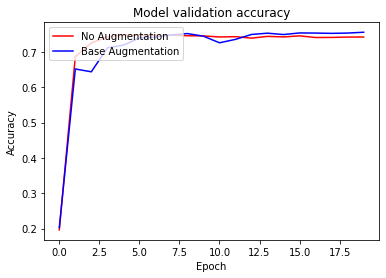

In [38]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.show()

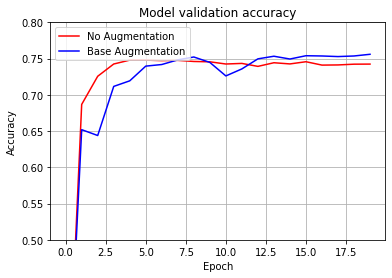

In [39]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Base Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

### Base & CutMix Augmentation 적용한 경우

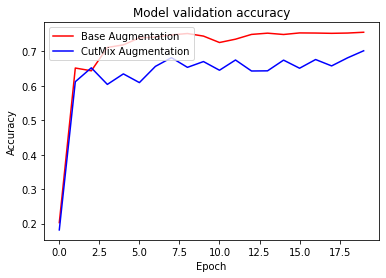

In [40]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.show()

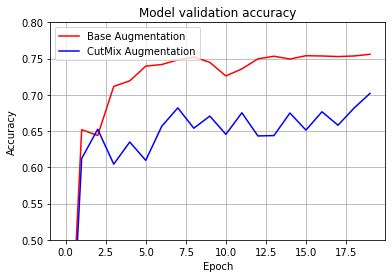

In [41]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'CutMix Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

### Base & MixUp Augmentation 적용한 경우

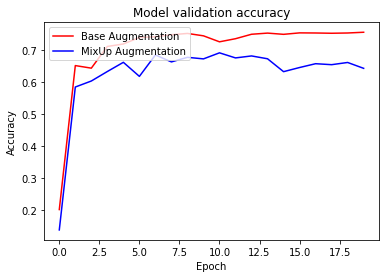

In [42]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.show()

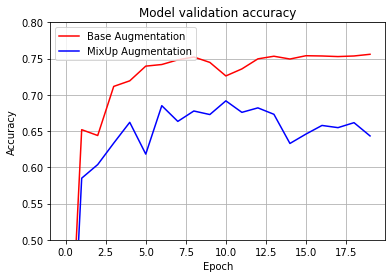

In [43]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Base Augmentation', 'MixUp Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

**No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용**   
이상 4가지 경우의 데이터셋에 대해 **훈련된 ResNet50 분류기**의 **견종 분류 정확도 성능을 비교**해 보고,   
**Augmentation 방법들의 영향도에 대해 분석**해 보세요.

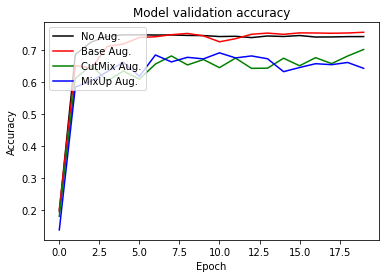

In [44]:
# 훈련 과정을 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Base Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.show()

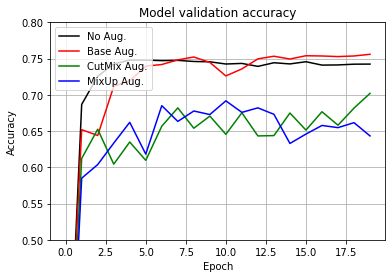

In [45]:
# 조금 더 확대해 살펴봅시다.
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'k')
plt.plot(history_resnet50_base_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug.', 'Base Aug.', 'CutMix Aug.', 'MixUp Aug.'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # (0.72, 0.76) : 20 epoch
plt.show()

## 회고

* 이미지 섞기에서 `ds_train_no_aug.take(1)`의 해석을 잘 못하여 해메었다.
  - `ds_train_no_aug`은 `apply_normalize_on_dataset()`함수에서 유래하였으며
  - 함수에 사용된 인수로 `batch_size=16`으로 `ds.batch(batch_size)`을 수행하였기 때문에
  - take(1)`image.shape`은 (16, 224, 224, 3)으로 16장의 사진이 있다.
  

* 3가지 조건의 augmentation 중에서 하나를 선택하기 위해서는
  - if ~ elif ~ else 구문으로 해야하는데 
  - 주어진 apply_normalize_on_dataset() 함수는 if ~ if ~ else 구문으로 되어있어서 혼란스러웠다.
  - if 구문을 3개 사용하여 조건에 맞는 augmentation을 수행하도록 하였다.


* def cutmix() 함수에서 리턴하는 값이 mixed_imgs, **mixed_label** 으로 되어 있는데
  - mixed_imgs, **mixed_labels** 으로 수정해야만 했다.


* loss 함수에 따른 입력 데이터의 형태를 어떻게 변경해줘야하는지 ????
  - lecture 과정에서는 sparse_categorical_crossentropy 사용하고
  - going deeper 과정에서는 categorical_crossentropy 사용함
  - label에 대해서 one-hot encoding 하면 된다.